In [121]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [122]:
import numpy as np
import pandas as pd

In [123]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [124]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
#from sqlalchemy import create_engine, inspect

In [125]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [126]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [127]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [128]:
#Assigning to variables, save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [129]:
# Create our session (link) from Python to the DB
session = Session(engine)
Meas_one = session.query(Measurement).first()
Meas_one.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19ee1213d88>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [130]:
Station = Base.classes.station
Stat_one = session.query(Measurement).first()
Stat_one.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x19ee1213d88>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

# Exploratory Climate Analysis

2016-08-23


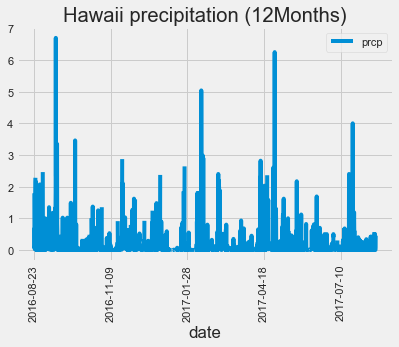

<Figure size 432x288 with 0 Axes>

In [142]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_yearDT= dt.date(2017,8, 23) - dt.timedelta(days=365)
print(last_yearDT)

# Perform a query to retrieve the data and precipitation scores
date_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_yearDT).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
date_df = pd.DataFrame(date_query, columns=['date', 'prcp'])
date_df.set_index('date', inplace=True)

# Sort the dataframe by date
date_df = date_df.sort_values("date")
date_df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
date_df.plot(title="Hawaii precipitation (12Months)", rot = 90)

plt.show()
plt.savefig('Hawaii Prcp 12Months')

In [132]:
date_df.head(10)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15


In [133]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_df.describe()

# Display a statistical overview of the DataFrame

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [134]:
# Design a query to show how many stations are available in this dataset?
stat_query = session.query(Station.station, Station.name).all()
stat_df = pd.DataFrame(stat_query, columns=['station', 'name'])
stat_df.set_index('station', inplace=True)

print("Total Number of Stations listed below = 9")
stat_df

Total Number of Stations listed below = 9


,name
station,
USC00519397,"WAIKIKI 717.2, HI US"
USC00513117,"KANEOHE 838.1, HI US"
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
USC00517948,"PEARL CITY, HI US"
USC00518838,"UPPER WAHIAWA 874.3, HI US"
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
USC00519281,"WAIHEE 837.5, HI US"
USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
USC00516128,"MANOA LYON ARBO 785.2, HI US"


In [135]:
# What are the most active stations? (i.e. what stations have the most rows)?
meas_act=session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order. created DataFrame for visual
meas_df = pd.DataFrame(meas_act, columns=['station', 'tobs'])
meas_df = meas_df.sort_values("tobs",ascending=False)
meas_df

,station,tobs
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [136]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 

most_active = "USC00519281"

# highest temperature recorded, and average temperature of the most active station?
most_act_stat=session.query(Measurement.station, Measurement.tobs).filter(Measurement.station >= most_active).all()
print(min(most_act_stat), max(most_act_stat))


most_act_statDF=pd.DataFrame(most_act_stat, columns=['station','Temps'])
most_act_statDF.describe()


('USC00519281', 54.0) ('USC00519523', 85.0)


,Temps
count,8165.000000
mean,73.569137
std,4.644150
min,54.000000
25%,71.000000
50%,74.000000
75%,77.000000
max,87.000000


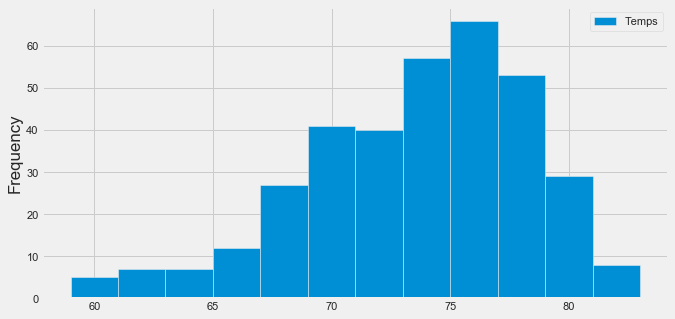

In [143]:
# Choose the station with the highest number of temperature observations.
most_active = "USC00519281"
most_act_year = session.query(Measurement.station, Measurement.tobs).\
filter(Measurement.station == most_active).\
filter(Measurement.date >= last_yearDT).all()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_act_year = pd.DataFrame(most_act_year, columns=['station','Temps'])

most_act_year.plot.hist(bins=12, figsize=(10, 5))
plt.savefig('Temps Most Active Station USC00519281')

## Bonus Challenge Assignment

In [138]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
#print(calc_temps('2012-02-28', '2012-03-05'))
print("Preferred Vacation week")
print(calc_temps('2015-08-30', '2015-09-10'))
print("Comparison June 2015") 
print(calc_temps('2015-06-1','2015-06-30'))
print("Comparison December 2015") 
print(calc_temps('2015-12-1','2015-12-30'))
#Print("December")

Preferred Vacation week
[(73.0, 78.76623376623377, 85.0)]
Comparison June 2015
[(66.0, 75.29452054794521, 81.0)]
Comparison December 2015
[(66.0, 73.61290322580645, 82.0)]


In [139]:
#My preferred vacation week 2015 temps for the year
One_year_start = dt.date(2015,8,30) - dt.timedelta(days=365)
One_year_end = dt.date(2015,9,10) - dt.timedelta(days=365)
print("Preferred Vacation Week Year Prior")
print(calc_temps(One_year_start, One_year_end))

Preferred Vacation Week Year Prior
[(71.0, 77.47560975609755, 84.0)]


In [140]:
import seaborn as sns

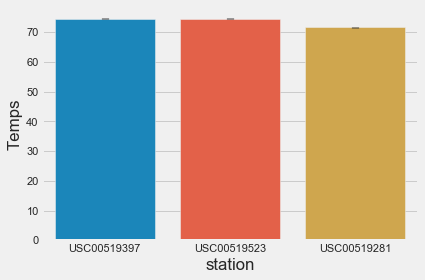

In [144]:
#Plot to try to explain Min Mean and MAX for these stations for year
sns.barplot(x='station', y='Temps', data=most_act_statDF.reset_index())  #'station','Temps'
plt.savefig('Temps Bonus')

In [117]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [118]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [119]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [120]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [95]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [50]:
# Plot the daily normals as an area plot with `stacked=False`
